In [1]:
import xarray as xr

In [2]:
from utils import *

In [3]:
# Request an additional 10 cores of power for processing from the server
client = get_cluster("UCSB0021", cores = 30)
# apply peer2peer network communication across multiple devices
client.cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hmchilders/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.88:33281,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hmchilders/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
def dashboard_wrangling(param, var):
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----            Parameter Data.          ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # NEED TO ADD NAME ATTRIBUTE IN WRANGLING PORTION
    params = param_wrangling()
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----        If-else Load Data       ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    filepath = os.path.join("saves", f"{var}.nc")
    if os.path.exists(filepath):
         #read in the file as a dataset
        ds=xr.open_dataset('saves/'+var+'.nc')
    
        #then convert back to data array
        var_avg = ds[var]
    else:
        print(f"Reading and wrangling your data, this may take a few minutes")
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # ----    Subset User Selection Funct     ----
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        var_da = subset_var_cluster(var)

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # ----      Subset Var Wrangle Funct      ----
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # NEED TO ADD NAME ATTRIBUTE IN WRANGLING PORTION
        var_avg = wrangle_var_cluster(var_da)

        #you ought to convert the data array to dataset before writing to file
        ds = var_avg.to_dataset(name = var)
        ds.to_netcdf('saves/'+var+'.nc') # note that this will throw error if you try to overwrite existing files

    results_df = train_emulator(params, var_avg)

    Plot1 = accuracy_plot(results_df) 
    Plot2 = emulator_plot(results_df)
    
    return Plot1, Plot2

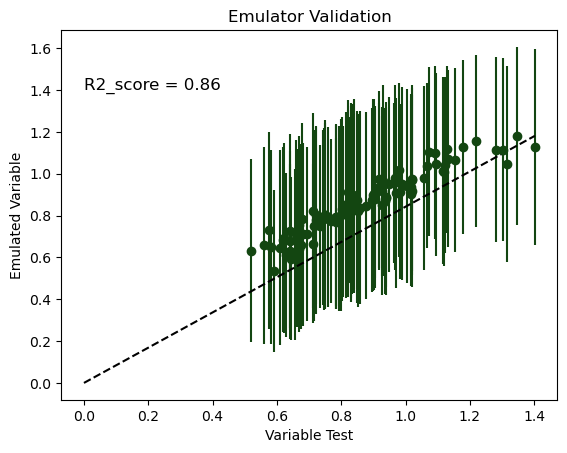

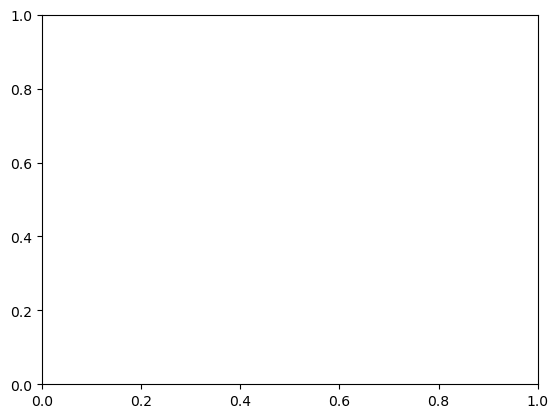

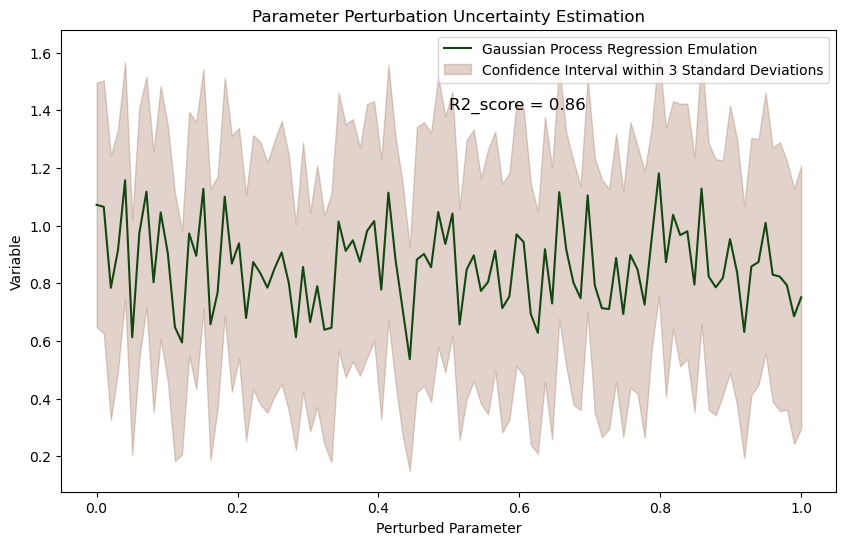

In [10]:
dashboard_wrangling('leafcn', 'LNC');

# End of working function

# Issue: I can only make one output, plots 2 but only top figure updates

In [6]:
def dashboard_wrangling_check(param, var):
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----            Parameter Data.          ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # NEED TO ADD NAME ATTRIBUTE IN WRANGLING PORTION
    params = param_wrangling()
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----        If-else Load Data       ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    filepath = os.path.join("saves", f"{var}.nc")
    if os.path.exists(filepath):
         #read in the file as a dataset
        ds=xr.open_dataset('saves/'+var+'.nc')
    
        #then convert back to data array
        var_avg = ds[var]
    else:
        print(f"Reading and wrangling your data, this may take a few minutes")
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # ----    Subset User Selection Funct     ----
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        var_da = subset_var_cluster(var)

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # ----      Subset Var Wrangle Funct      ----
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # NEED TO ADD NAME ATTRIBUTE IN WRANGLING PORTION
        var_avg = wrangle_var_cluster(var_da)

        #you ought to convert the data array to dataset before writing to file
        ds = var_avg.to_dataset(name = var)
        ds.to_netcdf('saves/'+var+'.nc') # note that this will throw error if you try to overwrite existing files

    results_df = train_emulator(params, var_avg)
    
    Plot1 = accuracy_plot(results_df)
    plot1 = pn.pane.Matplotlib(Plot1)
    #Plot2 = emulator_plot(results_df)
    #plot2 = pn.pane.Matplotlib(Plot1)
    
    return plot1

In [7]:
class Selections(param.Parameterized):
    parameter   = param.Selector(objects=['leafcn'])
    variable   = param.Selector(objects=['GPP', 'NBP', 'TOTVEGC', 'TLAI', 'EFLX_LH_TOT', 'SOILWATER_10CM', 'QRUNOFF', 'FSR', 'FAREA_BURNED', 'SNOWDP'])
    
    def view(self):
        return dashboard_wrangling_check(self.parameter, self.variable)

Row
    [0] Column(margin=(5, 10), name='Selections')
        [0] StaticText(value='<b>Selections</b>')
        [1] Select(name='Parameter', options=OrderedDict([('leafcn', ...]), value='leafcn')
        [2] Select(name='Variable', options=OrderedDict([('GPP', ...]), value='GPP')
    [1] ParamMethod(method, _pane=Matplotlib, defer_load=False)
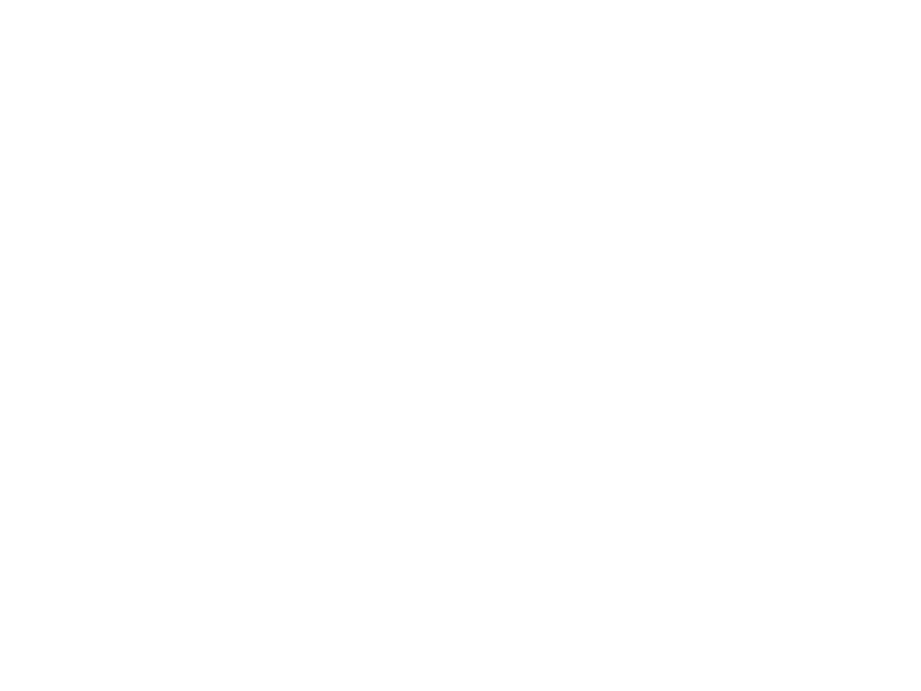

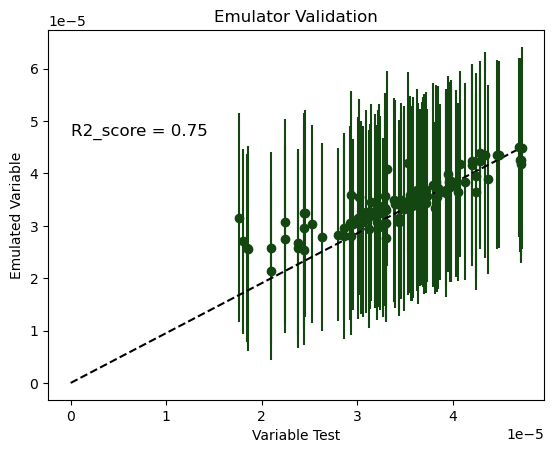

In [8]:
obj = Selections()
pn.Row(obj.param, obj.view)

# Isssue:

In [3]:
def dashboard_wrangling_check2(param, var):
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----            Parameter Data.          ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # NEED TO ADD NAME ATTRIBUTE IN WRANGLING PORTION
    params = param_wrangling()
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----        If-else Load Data       ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    filepath = os.path.join("saves", f"{var}.nc")
    if os.path.exists(filepath):
         #read in the file as a dataset
        ds=xr.open_dataset('saves/'+var+'.nc')
    
        #then convert back to data array
        var_avg = ds[var]
    else:
        print(f"Reading and wrangling your data, this may take a few minutes")
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # ----    Subset User Selection Funct     ----
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        var_da = subset_var_cluster(var)

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # ----      Subset Var Wrangle Funct      ----
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # NEED TO ADD NAME ATTRIBUTE IN WRANGLING PORTION
        var_avg = wrangle_var_cluster(var_da)

        #you ought to convert the data array to dataset before writing to file
        ds = var_avg.to_dataset(name = var)
        ds.to_netcdf('saves/'+var+'.nc') # note that this will throw error if you try to overwrite existing files

    results_df = train_emulator(params, var_avg)
    
    Plot1 = accuracy_plot(results_df)
    Plot2 = emulator_plot(results_df)
    
    return Plot1, Plot2

(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

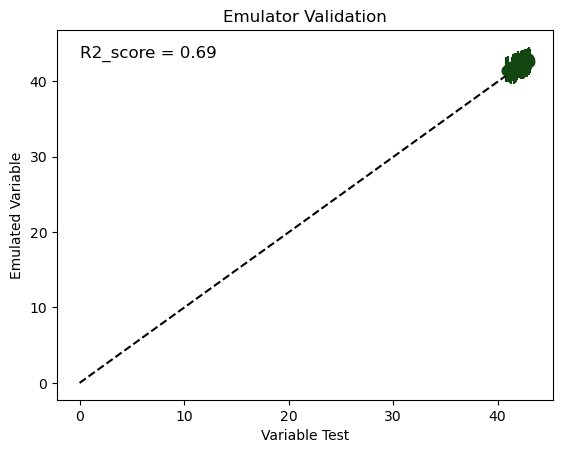

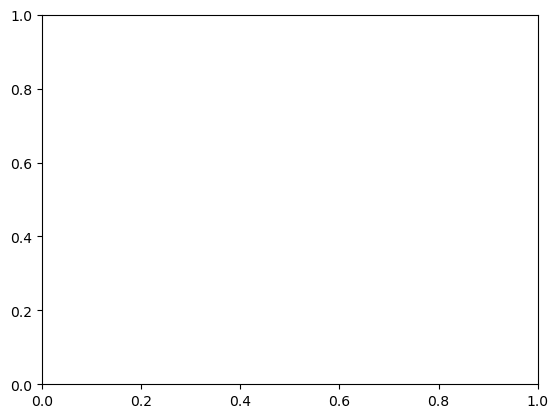

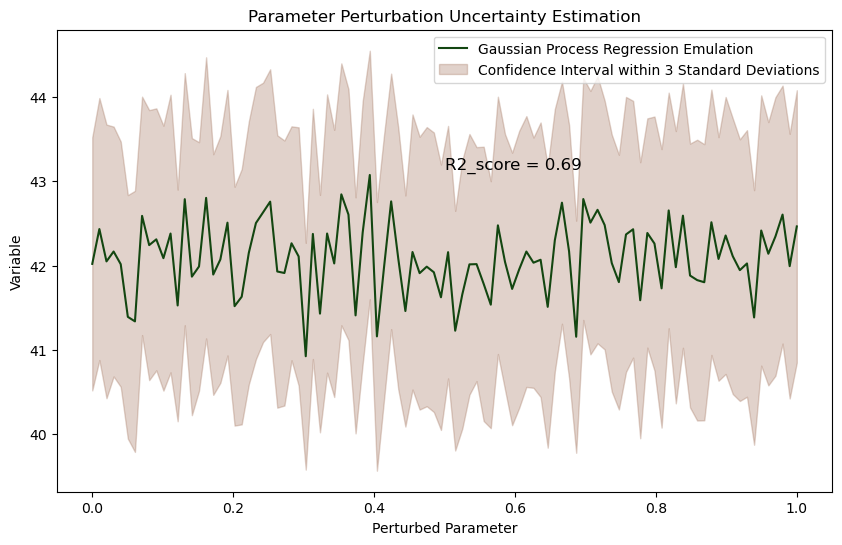

In [4]:
dashboard_wrangling_check2('leafcn', 'FSR')

Row
    [0] Column(margin=(5, 10), name='Selections')
        [0] StaticText(value='<b>Selections</b>')
        [1] Select(name='Parameter', options=OrderedDict([('leafcn', ...]), value='leafcn')
        [2] Select(name='Variable', options=OrderedDict([('GPP', ...]), value='GPP')
    [1] ParamMethod(method, _pane=Column, defer_load=False)
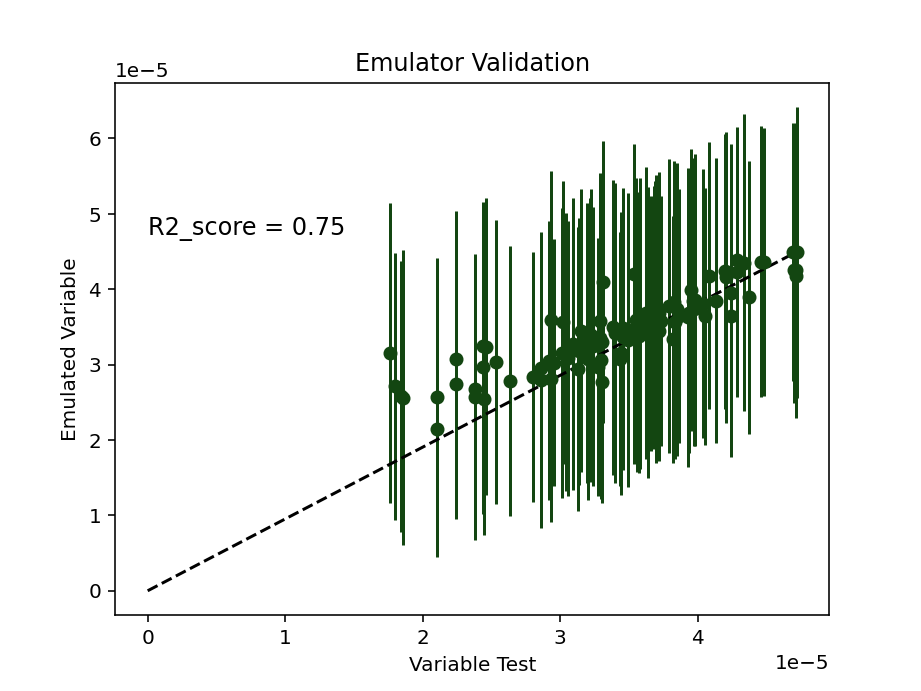
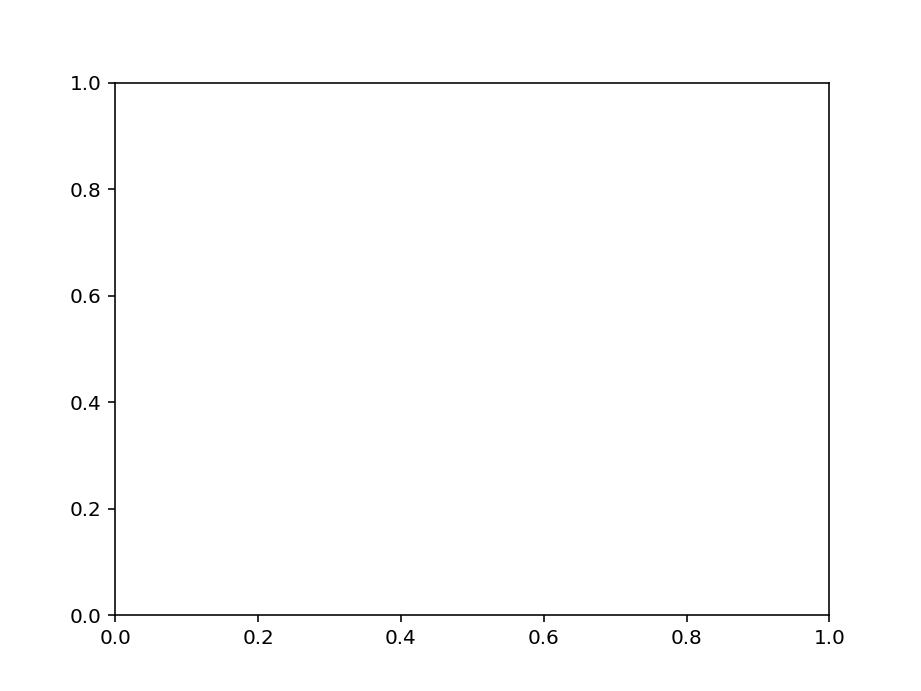

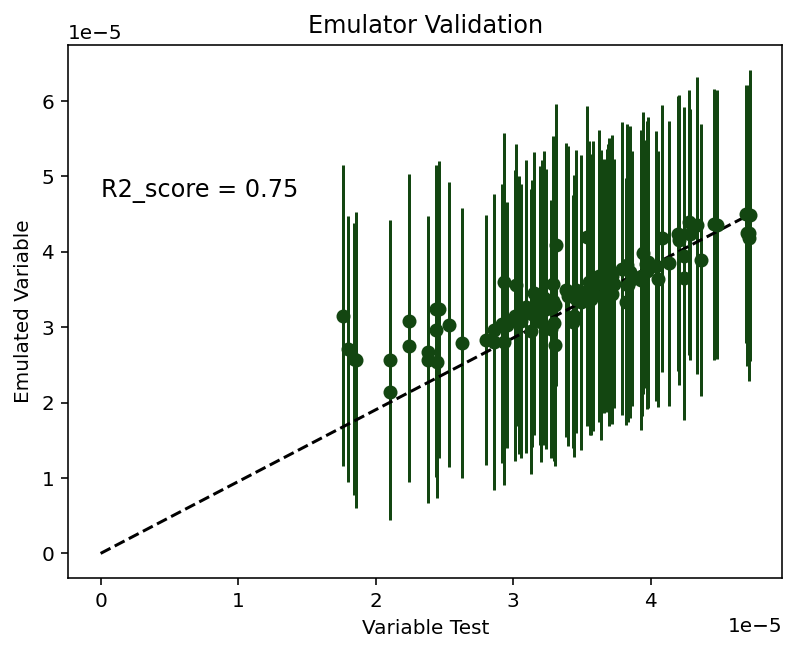

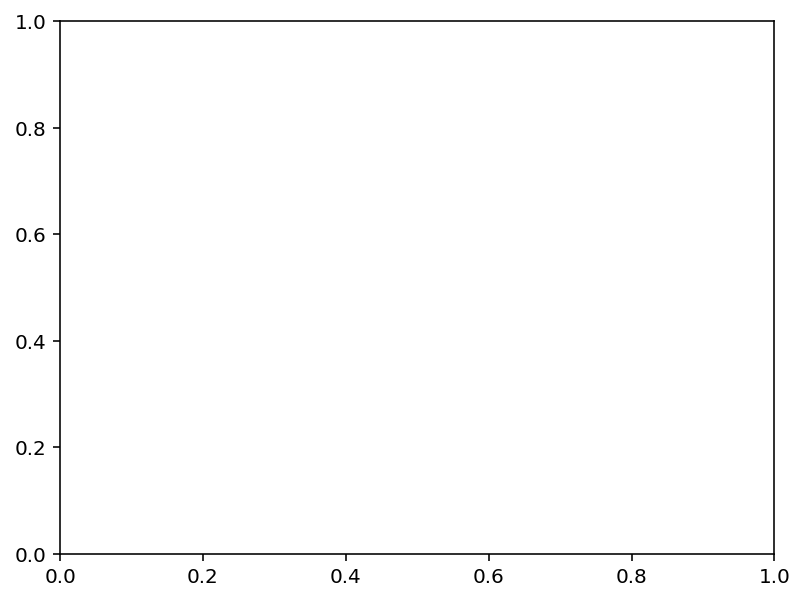

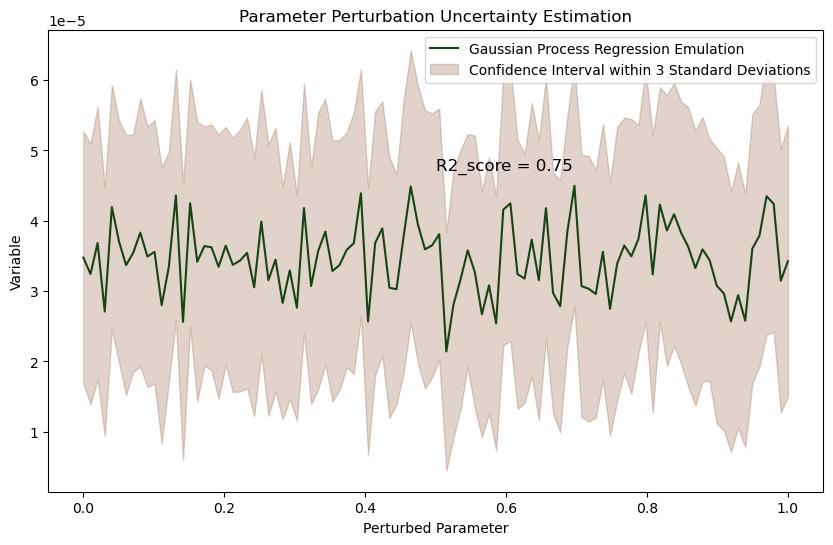

In [16]:
class Selections(param.Parameterized):
    parameter = param.Selector(objects=['leafcn'])
    variable = param.Selector(objects=['GPP', 'NBP', 'TOTVEGC', 'TLAI', 'EFLX_LH_TOT', 'SOILWATER_10CM', 'QRUNOFF', 'FSR', 'FAREA_BURNED', 'SNOWDP'])

    def view(self):
        # Call dashboard_wrangling with the selected parameter and variable
        plots = dashboard_wrangling_check2(self.parameter, self.variable)

        # Convert Matplotlib figures to Panel objects
        plot_pane1 = pn.pane.Matplotlib(plots[0])
        plot_pane2 = pn.pane.Matplotlib(plots[1])

        # Return a Panel layout containing the converted Panel objects
        return pn.Column(plot_pane1, plot_pane2)

# Create an instance of Selections and display it using Panel
obj = Selections()
pn.Row(obj.param, obj.view).servable()